In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
r=102303951

In [3]:
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)

In [6]:
data = pd.read_csv("/content/data.csv",encoding="ISO-8859-1",low_memory=False)
x = pd.to_numeric(data["no2"], errors="coerce")
x = x.dropna().values
x = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)


In [8]:
def transform(x):
    return a_r * torch.sin(b_r * x)

z_real = transform(x)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [11]:
G = Generator()
D = Discriminator()

loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)


In [12]:
epochs = 2000
batch = 64

In [14]:
for e in range(epochs):
    idx = np.random.randint(0, len(z_real), batch)
    real = z_real[idx]

    real_y = torch.ones(batch, 1)
    fake_y = torch.zeros(batch, 1)

    noise = torch.randn(batch, 1)
    fake = G(noise)

    d_loss = loss_fn(D(real), real_y) + loss_fn(D(fake.detach()), fake_y)
    opt_D.zero_grad()
    d_loss.backward()
    opt_D.step()

    g_loss = loss_fn(D(fake), real_y)
    opt_G.zero_grad()
    g_loss.backward()
    opt_G.step()
with torch.no_grad():
    z_f = G(torch.randn(2000, 1)).numpy()

kde = KernelDensity(kernel="gaussian", bandwidth=0.3)
kde.fit(z_f)

z_vals = np.linspace(z_f.min(), z_f.max(), 500).reshape(-1, 1)
pdf_vals = np.exp(kde.score_samples(z_vals))


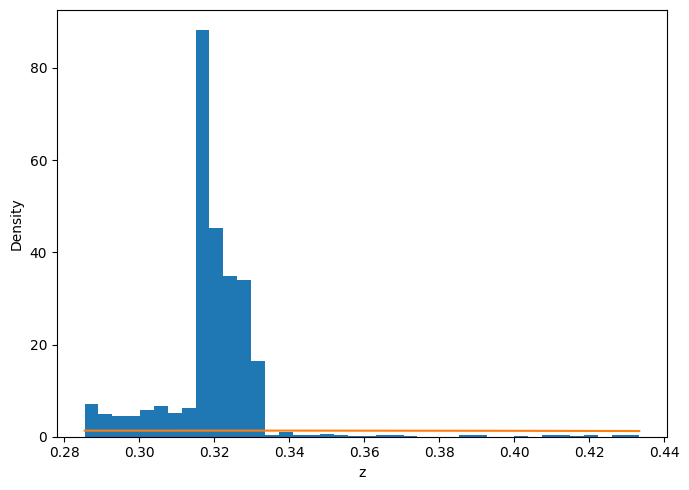

In [17]:
plt.figure(figsize=(7,5))
plt.hist(z_f, bins=40, density=True)
plt.plot(z_vals, pdf_vals)
plt.xlabel("z")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("gan_pdf_plot.png")
plt.show()